<a href="https://colab.research.google.com/github/seschm/Internship-Gaertner/blob/main/NN_for_SIC_POVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit, vmap, pmap, grad
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import torch.utils.data as data
from functools import partial

import itertools

from tqdm.auto import tqdm
import random as rng

import numpy as np
import scipy as sp
from numpy import sqrt, cos, sin, exp, pi, log2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from scipy.stats import norm

In [2]:
def generate_random_pure_state(nQubit):
    """
    Generates Haar random pure state.
    To generate a random pure state, take any basis state, e.g. |00...00>
    and apply a random unitary matrix. For consistency each basis state should be the same.
    """
    baseRho=np.zeros((2**nQubit,2**nQubit),dtype=complex)
    baseRho[0,0]=1
    U=unitary_group.rvs(2**nQubit)
    return U@baseRho@U.conj().T

In [3]:
def generate_single_qubit(theta,phi):
    """
    Generates single qubit out of the given angles theta and phi.
    First construct the single qubit state as an array of shape (2, 1).
    Then compute the matrixproduct with its adjoint state.
    """
    state = np.array([[cos(theta/2)],[sin(theta/2)*exp(phi*1.j)]])
    return state@state.conj().T

In [4]:
def generate_random_seperable_pure_state(nQubit):
    """
    Generates random seperable pure state.
    First generate the desired number of random pure states.
    Then tensor them together.
    """
    single_qubits = []
    for i in range(0,nQubit):
        single_qubits.append(generate_random_pure_state(1))
    tensored_qubits = [single_qubits[0]]
    for i in range(1,nQubit):
        tensored_qubits.append(np.kron(tensored_qubits[-1],single_qubits[i]))
    return tensored_qubits[-1]

In [5]:
def depolarizing_channel(state,p):
    """
    Applies a depolarizing channel to the given state with p the probability of the completely mixed state.
    """
    d=len(state[0])
    return p*np.eye(d)/d+(1-p)*state

In [6]:
def generate_POVM(theta,phi,nQubit):
    """
    Generates a POVM consisting of multi qubit projectors on to the axis defined by the two angles theta and phi.
    First generates all possible states (combinations of spin up and down) as strings containing 1s and 0s.
    The order is equal to binary counting.
    Then generates the single qubit projector and its orthogonal projector.
    In the next step all single qubit projectors corresponding to the same state are gathered in the correct order and then tensored together to get an element of the POVM.
    Returns the POVM with the elements beeing ordered equal to binary counting (-> up ... up, up ... up down, up ... up down up, ...).
    """
    up_and_downs = []

    for i in range(2**nQubit):
        binary = bin(i)[2:]
        zeros = np.zeros(nQubit-len(binary), dtype=int)
        for k in range(nQubit-len(binary)):
            binary = '0' + binary
        up_and_downs.append(binary)

    projector=generate_single_qubit(theta,phi)
    orthogonal_projector = np.eye(2)-projector
    POVM = []

    for i in range(2**nQubit):
        tensored_projector = []
        single_projectors = []
        for j in range(nQubit):
            if up_and_downs[i][j] == '0':
                single_projectors.append(projector)
            if up_and_downs[i][j] == '1':
                single_projectors.append(orthogonal_projector)
        tensored_projector.append(single_projectors[0])
        for k in range(nQubit-1):
            tensored_projector.append(np.kron(tensored_projector[-1],single_projectors[k+1]))
        POVM.append(tensored_projector[-1])

    return POVM

In [7]:
def generate_pauli6(nQubits):
    '''
    '''
    X_plus = generate_single_qubit(pi/2,0)
    X_minus = np.eye(2)-X_plus
    Y_plus = generate_single_qubit(pi/2,pi/2)
    Y_minus = np.eye(2)-Y_plus
    Z_plus = generate_single_qubit(0,0)
    Z_minus = np.eye(2)-Z_plus

    paulis = [X_plus,X_minus,Y_plus,Y_minus,Z_plus,Z_minus]
    indices = [0,1,2,3,4,5]
    ref_list_temp = []

    for comb in itertools.combinations_with_replacement(indices, nQubits):
        # Generate all permutations of the combination
        for perm in itertools.permutations(comb):
            ref_list_temp.append(perm)

    ref_list = list(dict.fromkeys(ref_list_temp))
    POVM = []

    for index, comb in enumerate(ref_list):
        POVM.append(paulis[comb[0]])
        for i in range(1,nQubits):
            POVM[index] = np.kron(POVM[index],paulis[comb[i]])

    return POVM

In [8]:
def perform_multi_qubit_measurement(state,POVM):
    """
    Performs a multi qubit measurement with the given POVM.
    """
    probabilities = np.einsum('lii->l',np.einsum('ij,ljk->lik',state,POVM))
    return probabilities

In [9]:
def perform_noisy_multi_qubit_measurement(state,POVM,p):
    """
    Generates probabilities of the noisy state.
    First applies the noise, then generates the probabilities.
    """
    noisy_state = depolarizing_channel(state,p)
    return perform_multi_qubit_measurement(noisy_state,POVM)

In [10]:
def cholesky_decomposition(state):
    '''
    '''
    n = len(state)
    A = np.zeros_like(state)

    for i in range(n):
        for j in range(i+1):
            if i == j:
                A[i][j] = np.sqrt(state[i][i] - np.sum(A[i][:j]**2))
            else:
                A[i][j] = (state[i][j] - np.sum(A[i][:j]*A[j][:j])) / A[j][j]

    return A

In [11]:
def sampling(probabilities,samplesize):
    """
    Takes in a probability distribution and samples from it.
    """
    sampling = rng.choices(np.arange(0,len(probabilities)), weights=probabilities, k=samplesize)
    sampled_probabilities = []
    for element in np.arange(0,len(probabilities)):
        sampled_probabilities.append(sampling.count(element)/samplesize)
    return sampled_probabilities

In [12]:
@partial(jit,static_argnums=(4,5))  # Jit the function for efficiency
def loss_fn(state, params, batch_input, batch_target_output,nQubits,batch_size):
    '''
    '''
    pred = state.apply_fn(params, batch_input)

    B = jnp.reshape(jnp.asarray(pred),(batch_size,2**nQubits,2**nQubits))
    #C = jnp.einsum('ijk,ilk->ijl',B,1.j*B)
    O = jnp.einsum('ijk->ikj',B)
    C = B + 1.j*O
    Tri = jnp.tril(jnp.ones((batch_size,2**nQubits,2**nQubits)))
    D = jnp.multiply(C,Tri)
    Re_Diag = jnp.real(jnp.diagonal(D, axis1=-2, axis2=-1))
    A = jnp.copy(D)
    A = A.at[..., jnp.arange(2**nQubits), jnp.arange(2**nQubits)].set(Re_Diag)

    #A = jnp.zeros((batch_size,2**nQubits,2**nQubits), dtype=complex)
    #for k in range(batch_size):            # state
    #    counter = 0
    #    for j in range(2**nQubits):        # row
    #        for i in range(2**nQubits):    # column
    #            if i < j:
    #                A = A.at[k,j,i].set(pred[k,counter]+pred[k,counter+1]*1.j)
    #                counter += 2
    #            if i == j:
    #                A = A.at[k,j,i].set(pred[k,counter])
    #                counter += 1
    pred_den_unn = jnp.einsum('ijk,ilk->ijl',A,A.conj())
    trace_inv = 1/ jnp.trace(pred_den_unn,axis1=1,axis2=2)
    pred_den = jnp.einsum('ijk,i->ijk',pred_den_unn,trace_inv)
    matrix_product = jnp.einsum('ijk,ikl->ijl',pred_den,batch_target_output)
    loss = jnp.mean(1-jnp.trace(matrix_product,axis1=1,axis2=2))
    #print(Tri)
    return jax.lax.real(loss)

In [13]:
@partial(jit,static_argnums=(3,4))  # Jit the function for efficiency
def train_step(state, batch_input, batch_target_output,nQubit,batch_size):
    # Gradient function
    grad_fn = jax.value_and_grad(loss_fn,# Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, batch_input, batch_target_output,nQubit,batch_size)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [14]:
def train_model(state, batched_training_input, batched_training_target_outputs, acc_input, acc_target_output, batched_te_unm_den,nQubits,batch_size, num_epochs = 100):

  acc = []
  acc_train = []
  acc_unmit = []

  for epoch in tqdm(range(num_epochs)):
    acc_train_temp = []
    acc_temp = []
    acc_unmit_temp = []
    for i in range(len(batched_training_input)):
        state, loss = train_step(state, batched_training_input[i], batched_training_target_outputs[i],nQubits,batch_size)
        acc_train_temp.append(loss_fn(state,state.params,batched_training_input[i], batched_training_target_outputs[i],nQubits,batch_size))
    for j in range(len(acc_input)):
        acc_temp.append(loss_fn(state,state.params,acc_input[j], acc_target_output[j],nQubits,batch_size))
        matrix_product = jnp.einsum('ijk,ikl->ijl',batched_te_unm_den[j],acc_target_output[j])
        acc_unmit_temp.append(1-jnp.trace(matrix_product))
    acc_train.append(jnp.mean(jnp.asarray(acc_train_temp)))
    acc.append(jnp.mean(jnp.asarray(acc_temp)))
    acc_unmit.append(jnp.mean(jnp.asarray(acc_unmit_temp)))

  return state, acc, acc_train, acc_unmit

In [15]:
def shuffle_along_axis0(arr):
    rng_key = jax.random.PRNGKey(0)  # Initialize random number generator key
    permuted_indices = jax.random.permutation(rng_key, arr.shape[0])
    shuffled_arr = jnp.take(arr, permuted_indices, axis=0)
    return shuffled_arr

In [16]:
class MLP(nn.Module):

  num_neurons_per_layer : list[int]   # List containing the number of neurons per layer (except input layer)


  @nn.compact
  def __call__(self, x):
    activation = x
    for i, numb_neurons in enumerate(self.num_neurons_per_layer):
      activation = nn.Dense(numb_neurons)(activation) # tell how to initialize weigths -> reduce variance
      if i != len(self.num_neurons_per_layer) - 1:
        activation = nn.relu(activation)

    return activation

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0.98, 'Accuracy')

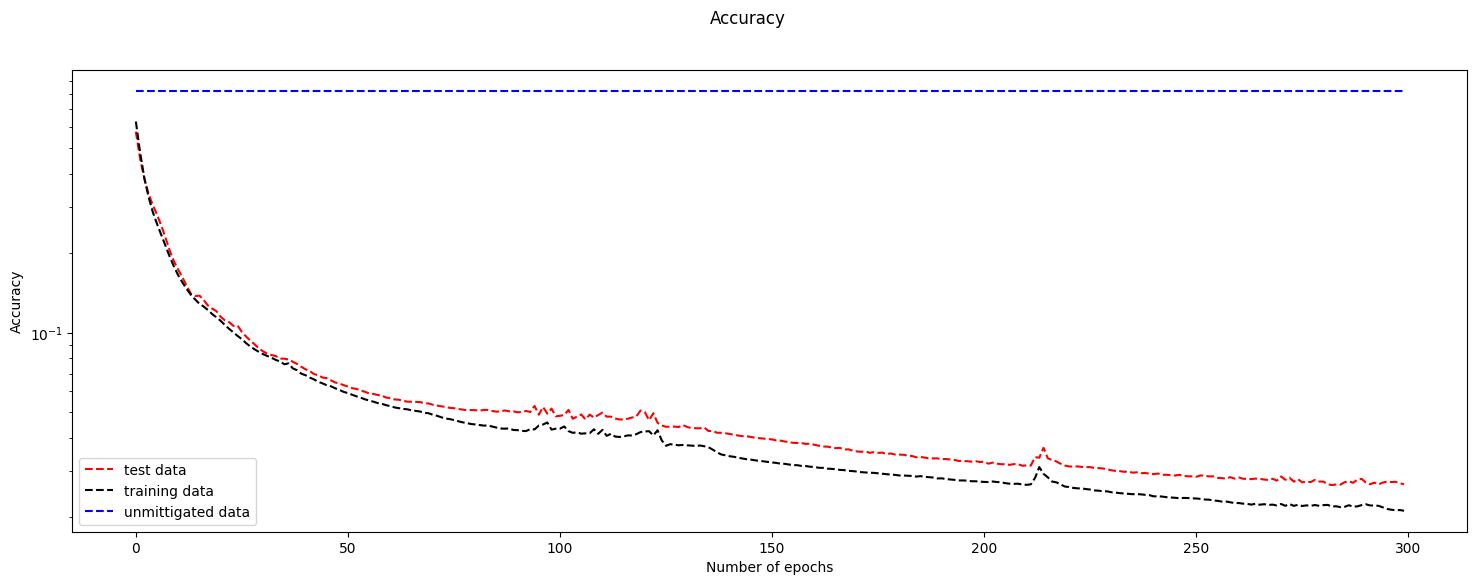

In [17]:
nQubit = 2
layers = [20,20,20,20,20,4**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 0.001
training_states = 2500
test_states = 200
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 6**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_pauli6(nQubit)
training_probs = []
training_den = []
test_probs = []
test_unm_den = []
test_den = []

for i in tqdm(range(training_states)):
    state = generate_random_seperable_pure_state(nQubit)
    training_den.append(state)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs,samplesize)
    training_probs.append(noisy_probs)

for i in tqdm(range(test_states)):
    state = generate_random_seperable_pure_state(nQubit)
    test_den.append(state)
    noisy_state = depolarizing_channel(state,p)
    test_unm_den.append(noisy_state)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs,samplesize)
    test_probs.append(noisy_probs)

training_probs_shuf = shuffle_along_axis0(jnp.asarray(training_probs))
training_As_shuf = shuffle_along_axis0(jnp.asarray(training_den))
test_probs_shuf = shuffle_along_axis0(jnp.asarray(test_probs))
test_As_shuf = shuffle_along_axis0(jnp.asarray(test_den))
test_unm_As_shuf = shuffle_along_axis0(jnp.asarray(test_unm_den))

batched_tr_probs = jnp.split(training_probs_shuf,int(len(training_probs_shuf)/batch_size),axis=0)
batched_tr_As = jnp.split(training_As_shuf,int(len(training_As_shuf)/batch_size),axis=0)
batched_te_probs = jnp.split(test_probs_shuf,int(len(test_probs_shuf)/batch_size),axis=0)
batched_te_As = jnp.split(test_As_shuf ,int(len(test_As_shuf)/batch_size),axis=0)
batched_te_unm_As = jnp.split(test_unm_As_shuf ,int(len(test_unm_As_shuf)/batch_size),axis=0)

state2, acc2, acc_train2, acc_unmit2 = train_model(model_state, jnp.asarray(batched_tr_probs), jnp.asarray(batched_tr_As),
                                                               jnp.asarray(batched_te_probs), jnp.asarray(batched_te_As),
                                                               jnp.asarray(batched_te_unm_As),
                                                               nQubits=nQubit,batch_size=batch_size, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(i,acc2,label="test data",linestyle="--",color="red")
ax.plot(i,acc_train2,label="training data",linestyle="--",color="black")
ax.plot(i,acc_unmit2,label="unmittigated data",linestyle="--",color="blue")
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Accuracy')
ax.set_yscale('log')
ax.legend()
fig.suptitle('Accuracy')

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy')

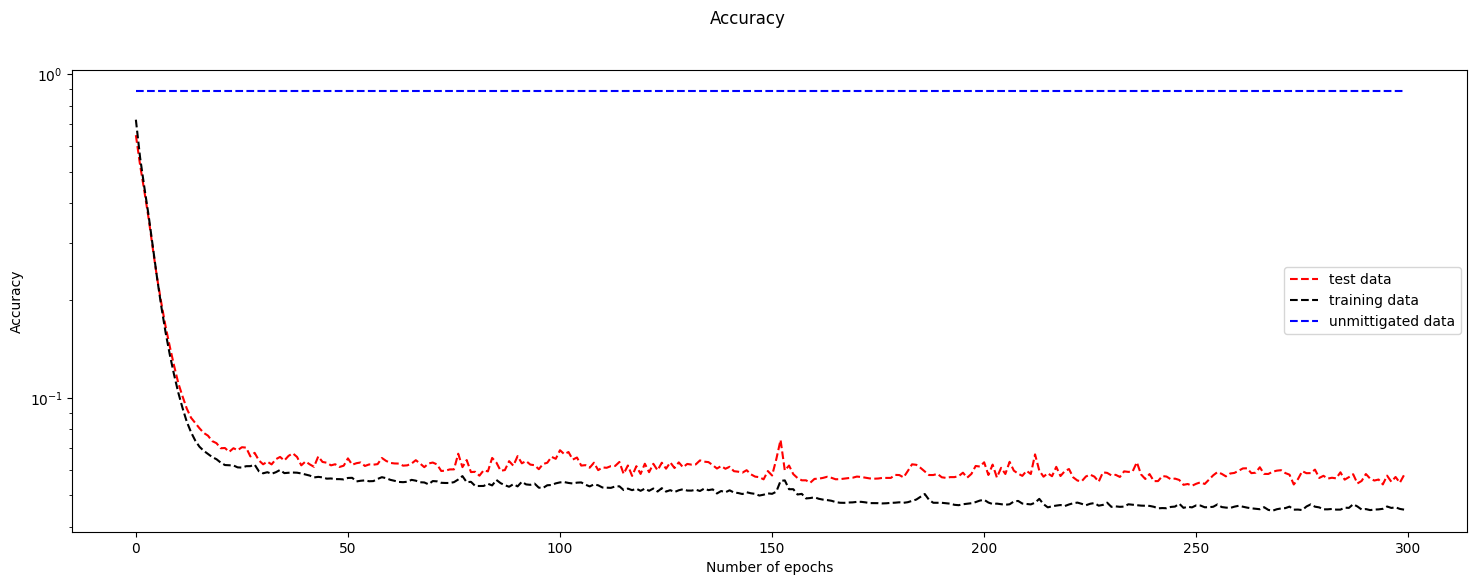

In [18]:
nQubit = 3
layers = [40,40,4**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 0.001
training_states = 5000
test_states = 200
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 6**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_pauli6(nQubit)
training_probs = []
training_den = []
test_probs = []
test_unm_den = []
test_den = []

for i in tqdm(range(training_states)):
    state = generate_random_seperable_pure_state(nQubit)
    training_den.append(state)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs,samplesize)
    training_probs.append(noisy_probs)

for i in tqdm(range(test_states)):
    state = generate_random_seperable_pure_state(nQubit)
    test_den.append(state)
    noisy_state = depolarizing_channel(state,p)
    test_unm_den.append(noisy_state)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs,samplesize)
    test_probs.append(noisy_probs)

training_probs_shuf = shuffle_along_axis0(jnp.asarray(training_probs))
training_As_shuf = shuffle_along_axis0(jnp.asarray(training_den))
test_probs_shuf = shuffle_along_axis0(jnp.asarray(test_probs))
test_As_shuf = shuffle_along_axis0(jnp.asarray(test_den))
test_unm_As_shuf = shuffle_along_axis0(jnp.asarray(test_unm_den))

batched_tr_probs = jnp.split(training_probs_shuf,int(len(training_probs_shuf)/batch_size),axis=0)
batched_tr_As = jnp.split(training_As_shuf,int(len(training_As_shuf)/batch_size),axis=0)
batched_te_probs = jnp.split(test_probs_shuf,int(len(test_probs_shuf)/batch_size),axis=0)
batched_te_As = jnp.split(test_As_shuf ,int(len(test_As_shuf)/batch_size),axis=0)
batched_te_unm_As = jnp.split(test_unm_As_shuf ,int(len(test_unm_As_shuf)/batch_size),axis=0)

state3, acc3, acc_train3, acc_unmit3 = train_model(model_state, jnp.asarray(batched_tr_probs), jnp.asarray(batched_tr_As),
                                                               jnp.asarray(batched_te_probs), jnp.asarray(batched_te_As),
                                                               jnp.asarray(batched_te_unm_As),
                                                               nQubits=nQubit,batch_size=batch_size, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(i,acc3,label="test data",linestyle="--",color="red")
ax.plot(i,acc_train3,label="training data",linestyle="--",color="black")
ax.plot(i,acc_unmit3,label="unmittigated data",linestyle="--",color="blue")
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Accuracy')
ax.set_yscale('log')
ax.legend()
fig.suptitle('Accuracy')

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy')

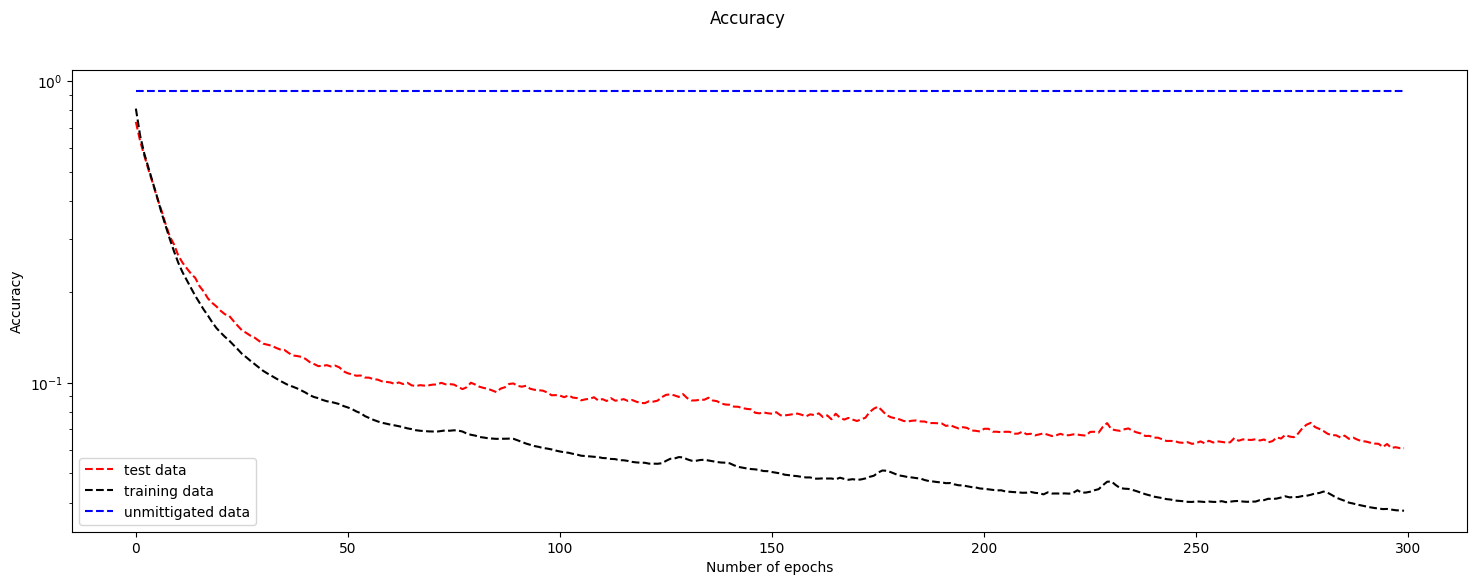

In [19]:
nQubit = 4
layers = [80,80,80,80,80,80,80,4**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 0.001
training_states = 10000
test_states = 200
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 6**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_pauli6(nQubit)
training_probs = []
training_den = []
test_probs = []
test_unm_den = []
test_den = []

for i in tqdm(range(training_states)):
    state = generate_random_seperable_pure_state(nQubit)
    training_den.append(state)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs,samplesize)
    training_probs.append(noisy_probs)

for i in tqdm(range(test_states)):
    state = generate_random_seperable_pure_state(nQubit)
    test_den.append(state)
    noisy_state = depolarizing_channel(state,p)
    test_unm_den.append(noisy_state)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs,samplesize)
    test_probs.append(noisy_probs)

training_probs_shuf = shuffle_along_axis0(jnp.asarray(training_probs))
training_As_shuf = shuffle_along_axis0(jnp.asarray(training_den))
test_probs_shuf = shuffle_along_axis0(jnp.asarray(test_probs))
test_As_shuf = shuffle_along_axis0(jnp.asarray(test_den))
test_unm_As_shuf = shuffle_along_axis0(jnp.asarray(test_unm_den))

batched_tr_probs = jnp.split(training_probs_shuf,int(len(training_probs_shuf)/batch_size),axis=0)
batched_tr_As = jnp.split(training_As_shuf,int(len(training_As_shuf)/batch_size),axis=0)
batched_te_probs = jnp.split(test_probs_shuf,int(len(test_probs_shuf)/batch_size),axis=0)
batched_te_As = jnp.split(test_As_shuf ,int(len(test_As_shuf)/batch_size),axis=0)
batched_te_unm_As = jnp.split(test_unm_As_shuf ,int(len(test_unm_As_shuf)/batch_size),axis=0)

state4, acc4, acc_train4, acc_unmit4 = train_model(model_state, jnp.asarray(batched_tr_probs), jnp.asarray(batched_tr_As),
                                                               jnp.asarray(batched_te_probs), jnp.asarray(batched_te_As),
                                                               jnp.asarray(batched_te_unm_As),
                                                               nQubits=nQubit,batch_size=batch_size, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(i,acc4,label="test data",linestyle="--",color="red")
ax.plot(i,acc_train4,label="training data",linestyle="--",color="black")
ax.plot(i,acc_unmit4,label="unmittigated data",linestyle="--",color="blue")
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Accuracy')
ax.set_yscale('log')
ax.legend()
fig.suptitle('Accuracy')

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy')

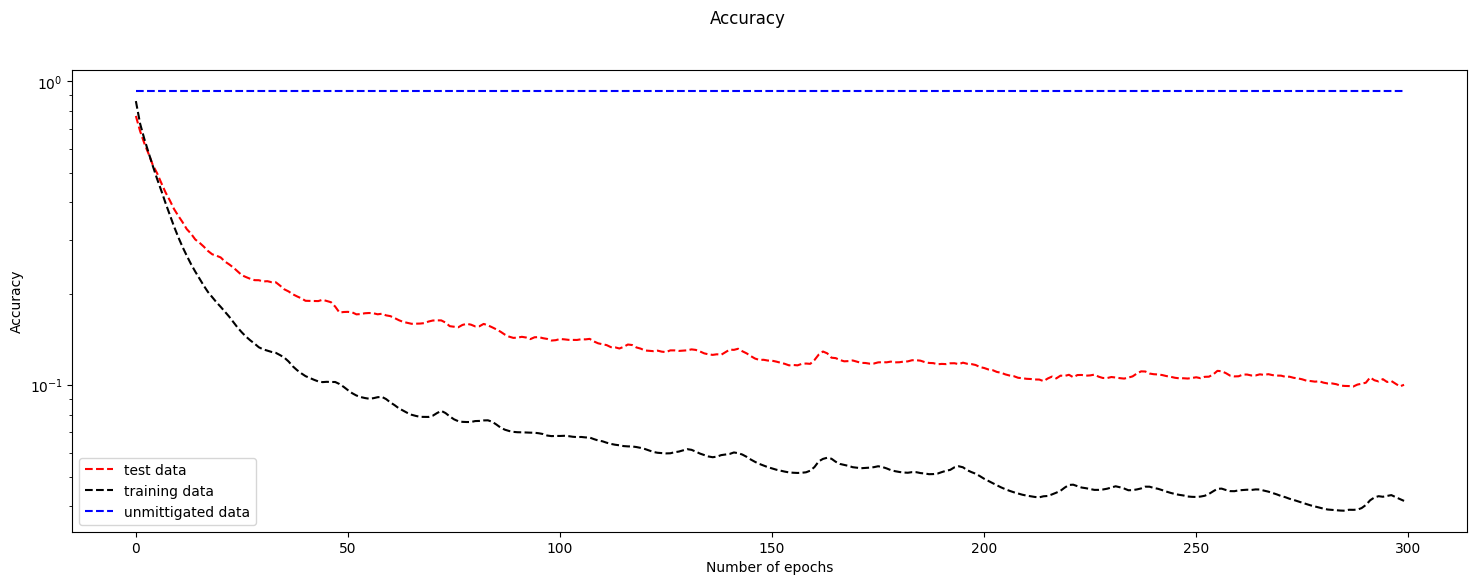

In [20]:
nQubit = 5
layers = [160,160,160,160,160,4**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 0.001
training_states = 12500
test_states = 200
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 6**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_pauli6(nQubit)
training_probs = []
training_den = []
test_probs = []
test_unm_den = []
test_den = []

for i in tqdm(range(training_states)):
    state = generate_random_seperable_pure_state(nQubit)
    training_den.append(state)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs,samplesize)
    training_probs.append(noisy_probs)

for i in tqdm(range(test_states)):
    state = generate_random_seperable_pure_state(nQubit)
    test_den.append(state)
    noisy_state = depolarizing_channel(state,p)
    test_unm_den.append(noisy_state)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs,samplesize)
    test_probs.append(noisy_probs)

training_probs_shuf = shuffle_along_axis0(jnp.asarray(training_probs))
training_As_shuf = shuffle_along_axis0(jnp.asarray(training_den))
test_probs_shuf = shuffle_along_axis0(jnp.asarray(test_probs))
test_As_shuf = shuffle_along_axis0(jnp.asarray(test_den))
test_unm_As_shuf = shuffle_along_axis0(jnp.asarray(test_unm_den))

batched_tr_probs = jnp.split(training_probs_shuf,int(len(training_probs_shuf)/batch_size),axis=0)
batched_tr_As = jnp.split(training_As_shuf,int(len(training_As_shuf)/batch_size),axis=0)
batched_te_probs = jnp.split(test_probs_shuf,int(len(test_probs_shuf)/batch_size),axis=0)
batched_te_As = jnp.split(test_As_shuf ,int(len(test_As_shuf)/batch_size),axis=0)
batched_te_unm_As = jnp.split(test_unm_As_shuf ,int(len(test_unm_As_shuf)/batch_size),axis=0)

state5, acc5, acc_train5, acc_unmit5 = train_model(model_state, jnp.asarray(batched_tr_probs), jnp.asarray(batched_tr_As),
                                                               jnp.asarray(batched_te_probs), jnp.asarray(batched_te_As),
                                                               jnp.asarray(batched_te_unm_As),
                                                               nQubits=nQubit,batch_size=batch_size, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(i,acc5,label="test data",linestyle="--",color="red")
ax.plot(i,acc_train5,label="training data",linestyle="--",color="black")
ax.plot(i,acc_unmit5,label="unmittigated data",linestyle="--",color="blue")
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Accuracy')
ax.set_yscale('log')
ax.legend()
fig.suptitle('Accuracy')

/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


Text(0.5, 0.98, 'NN for SIC-POVM')

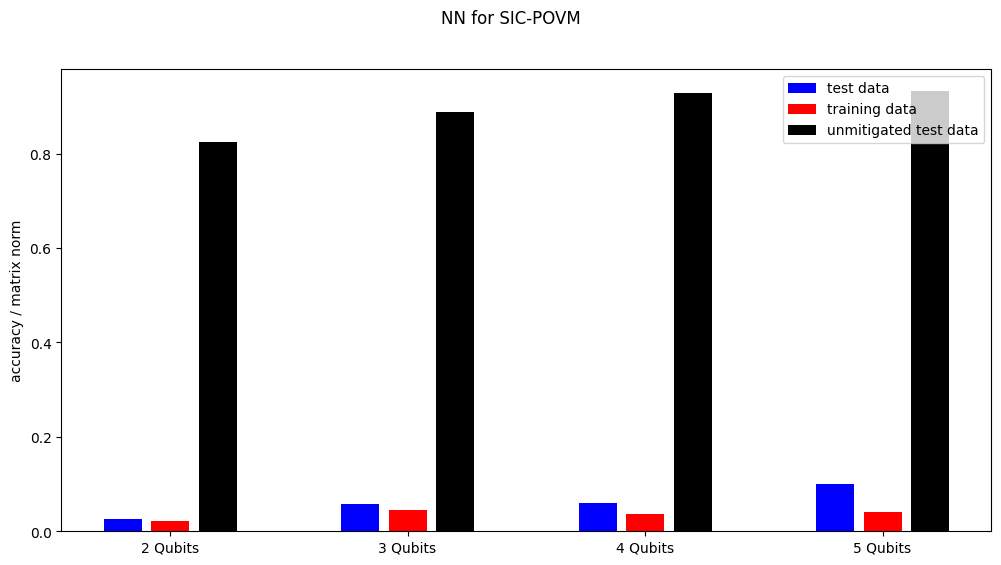

In [21]:
labels = ["2 Qubits","3 Qubits","4 Qubits","5 Qubits"]
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(0,acc2[-1],label="test data",color="blue")
ax.bar(1,acc_train2[-1],label="training data",color="red")
ax.bar(2,acc_unmit2[-1],label="unmitigated test data",color="black")
ax.bar(5,acc3[-1],color="blue")
ax.bar(6,acc_train3[-1],color="red")
ax.bar(7,acc_unmit3[-1],color="black")
ax.bar(10,acc4[-1],color="blue")
ax.bar(11,acc_train4[-1],color="red")
ax.bar(12,acc_unmit4[-1],color="black")
ax.bar(15,acc5[-1],color="blue")
ax.bar(16,acc_train5[-1],color="red")
ax.bar(17,acc_unmit5[-1],color="black")
ax.set_xticks([1,6,11,16])
ax.set_xticklabels(labels)
ax.set_xlabel("")
ax.set_ylabel("accuracy / matrix norm")
ax.legend()

fig.suptitle('NN for SIC-POVM')